In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import re
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Helper functions. The sigmoid and relu functions are used for forward prop, while the sigmoid_grad and relu_grad are used for backprop.

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def sigmoid_grad(dA, Z):
    return dA * sigmoid(Z) * (1-sigmoid(Z))

def relu_grad(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

## Another helper function, used by the processing unit to extract titles from names

This function uses regex to extract titles (the word which ends in '.') from the name column of the dataset

In [3]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

## Data processing function: Getting rid of the unwanted data, and normalizing features

The commented code was used earlier for visualization purposes

In [4]:
def visualize_data(data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    titles = {}
    survived_arr = []
    dead_arr = []
    
    for index, title in data["Title"].iteritems():
        if title not in titles:
            titles[title] = 1
        else:
            titles[title] += 1
            
    x = np.arange(len(titles))
    
    for title in titles:
        survived = np.sum((data["Survived"] == 1) & (data["Title"] == title))
        dead = titles[title] - survived
        survived_arr.append(survived)
        dead_arr.append(dead)
    
    
    rects1 = ax1.bar(x - 0.15, survived_arr, 0.3, label="Survived")
    rects2 = ax1.bar(x + 0.15, dead_arr, 0.3, label="Dead")
    ax1.set_xticks(x)
    ax1.set_xticklabels(titles)
    ax1.legend()
    
    def autolabel(rects, ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    
    ages = {}
    survived_arr = []
    dead_arr = []
    
    for index, age in data["Age_bin"].iteritems():
        if age not in ages:
            ages[age] = 1
        else:
            ages[age] += 1
            
    x = np.arange(len(ages))
    
    for age in ages:
        survived = np.sum((data["Survived"] == 1) & (data["Age_bin"] == age))
        dead = ages[age] - survived
        survived_arr.append(survived)
        dead_arr.append(dead)
        
    rects1 = ax2.bar(x - 0.15, survived_arr, 0.3, label="Survived")
    rects2 = ax2.bar(x + 0.15, dead_arr, 0.3, label="Dead")
    ax2.set_xticks(x)
    ax2.set_xticklabels(ages)
    ax2.legend()
    
    autolabel(rects1, ax2)
    autolabel(rects2, ax2)
    
    sexes = {}
    survived_arr = []
    dead_arr = []
    
    for index, sex in data["Sex"].iteritems():
        if sex not in sexes:
            sexes[sex] = 1
        else:
            sexes[sex] += 1
            
    x = np.arange(len(sexes))
    sexes_arr = []
    
    for sex in sexes:
        survived = np.sum((data["Survived"] == 1) & (data["Sex"] == sex))
        dead = sexes[sex] - survived
        if sex == 0: 
            sexes_arr.append("Male")
        else:
            sexes_arr.append("Female")
        survived_arr.append(survived)
        dead_arr.append(dead)
        
    rects1 = ax3.bar(x - 0.15, survived_arr, 0.3, label="Survived")
    rects2 = ax3.bar(x + 0.15, dead_arr, 0.3, label="Dead")
    ax3.set_xticks(x)
    ax3.set_xticklabels(sexes_arr)
    ax3.legend()
    
    autolabel(rects1, ax3)
    autolabel(rects2, ax3)
    
    sns.heatmap(data.corr(), annot=True,cmap='RdYlGn',linewidths=0.2, ax=ax4)
    
    fig.set_size_inches(15, 15)
    fig.tight_layout()
    plt.show()
    

In [5]:
def process_Data(data, plot=False):
    data = data.drop(["Cabin", "Ticket", "PassengerId"], axis=1)
    data["Sex"] = (data["Sex"] == "male").astype(int)
    for index, value in data["Embarked"].iteritems():
        if value == "S":
            data.loc[index, "Embarked"] = 1
        elif value == "C":
            data.loc[index, "Embarked"] = 2
        elif value == "Q":
            data.loc[index, "Embarked"] = 3
        else:
            data.loc[index, "Embarked"] = 0
    
    # Filling the missing data using the median of the age and fare columns respectively: 
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    
    # Splitting the ages and fares by categories
    data['Age_bin'] = pd.cut(data['Age'], bins=[0,10,18,35,120], labels=['Children','Teenage','Adult','Elder'])
    data['Fare_bin'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare','Average_fare','high_fare'])
    labels = np.array(data["Survived"])
    
    data["Embarked"].fillna(data["Embarked"].mode()[0], inplace = True)
    data["SibSp"].fillna(data["SibSp"].mean(skipna=True))
    data["Parch"].fillna(data["Parch"].mean(skipna=True))
    
    # Engineering the family size
    data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
    
    # Engineering the titles
    data["Title"] = data["Name"].apply(get_title)
    
    if plot is True:
        visualize_data(data)
    
    data["Title"] = data["Title"].replace(["Lady", "Countess", "Sir", "Jonkheer", "Dona", "Don"], "Important")
    data["Title"] = data["Title"].replace(["Capt", "Col", "Dr", "Major", "Rev"], "Officer")    
    data["Title"] = data["Title"].replace("Mlle", "Miss")
    data["Title"] = data["Title"].replace("Ms", "Miss")
    data["Title"] = data["Title"].replace("Mme", "Mrs")
    data = pd.get_dummies(data, columns=["Pclass", "Age_bin", "Fare_bin", "Title"])
    labels = np.array(data["Survived"])
    data = data.drop(["Name", "SibSp", "Parch", "Survived", "Age", "Fare"], axis=1)
    
    return np.array(data), labels

### Following code will get the data and show a heatmap with corellations between the columns. Hopefully, the data won't be too corellated

And besides the sex with the Mr. and Miss titles (which to be honest were obviously going to be corellated), and the sibsp and parch with the family size, which was engineered from those two, the data is pretty clean!

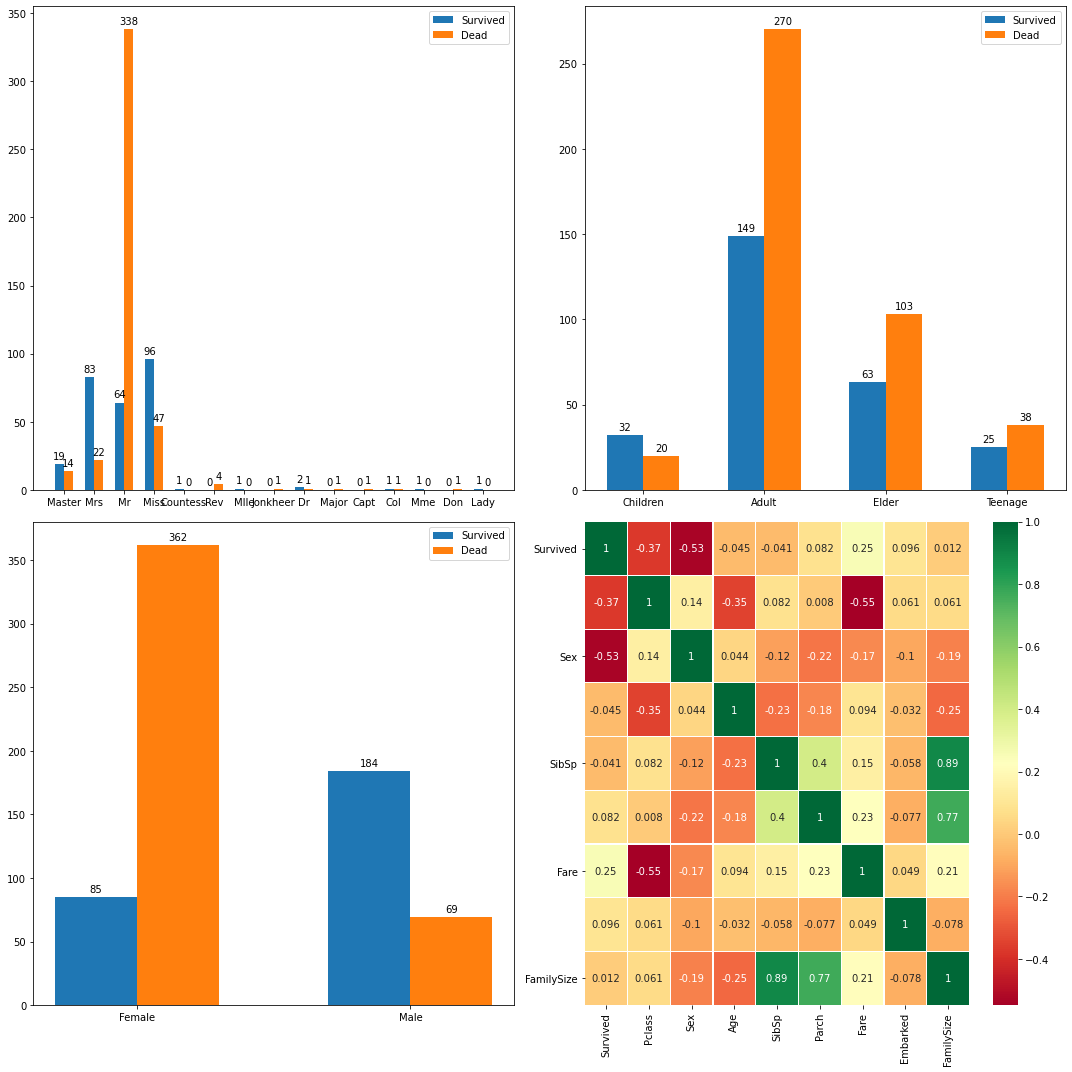

In [6]:
data = pd.read_csv("input/train.csv")
data = data.sample(frac=1)
data_train = data.head(700)
data_cv = data.tail(190)
X, Y = process_Data(data_train, True)
X = X.T
Y = Y.reshape((1, Y.shape[0]))

### Now we get to the modeling! This function is used to initialize parameters for a deep neural network, with given layer dimensions

In [7]:
 def init_params(layers_dims):
    parameters = {}
    
    L = len(layers_dims)
    
    for i in range(1, L):
        parameters["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i - 1]) * np.sqrt(2 / layers_dims[i - 1])
        parameters["b" + str(i)] = np.zeros((layers_dims[i], 1))
    
    return parameters
        

Following functions are required by the forward model, which will pass through all the examples and do the forward propagation for all the examples in a batch

In [8]:
def forward_step(A_prev, W, b):
    Z = W.dot(A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

In [9]:
def forward_activation_step(A_prev, W, b, activation: str):
    Z, cache = forward_step(A_prev, W, b)
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    else:
        A = relu(Z)
        
    cache = Z, *cache
    
    return A, cache

### Modeling the forward propagation for a whole batch of examples

All layers are using relu activation, except the last one, which uses sigmoid activation to normalize the result in the [0, 1] range (or 0% - 100%)

In [10]:
def forward_model(X, parameters):
    caches = []
    
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = forward_activation_step(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = forward_activation_step(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches

Computing the cost for the results predicted in the forward propagation step.

The 1e-8 is used as good measure, so that we don't get to an unwanted log(0) case, which is undefined.

Also, the cost uses L2 regularization, so that must be taken into account in the backprop phase

In [11]:
def cost(Y, AL, params, lambd):
    m = Y.shape[1]
    L2_reg = 0
    for param in params:
        L2_reg += np.sum(params[param] ** 2)
    
    mycost = np.squeeze(-1/m * np.sum(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8)) + 1/(2 * m) * lambd * L2_reg)
    return mycost 

Following functions are used by the backward model, which will do backprop on a whole batch

This first function only computes the derivatives for the activations, weights, and biases with respect to the previous layer, using the chain rule. Also, notice how for the weights we derivate the cost still using the L2 regularization.

This regularization is needed in case we overfit to our dataset, since the dataset isn't too large (only 890 examples), so with our neural network we really might overfit.

In [12]:
def backward_step(dZ, lambd, cache):
    Z, A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = dZ.dot(A_prev.T) + lambd / m * W
    db = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T.dot(dZ)
    
    return dA_prev, dW, db

This function takes into account the activation function used by the layer to first compute the derivative of a layer with respect to it's previous layers' activation, and then calls on "backward_step"

In [13]:
def backward_activation_step(dA, cache, lambd, activation: str):
    Z, A_prev, W, b = cache
    
    if activation == "sigmoid":
        dZ = sigmoid_grad(dA, Z)
    else: 
        dZ = relu_grad(dA, Z)
    
    dA_prev, dW, db = backward_step(dZ, lambd, cache)
    return dW, db, dA_prev

### Modeling backprop for a whole batch

In [14]:
def backward_model(AL, Y, caches, lambd):
    
    m = Y.shape[1]
    grads = {}
    L = len(caches)
    current_cache = caches[L - 1]
    
    dAL = -1/m * (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))
    grads["dW" + str(L)], grads["db" + str(L)], grads["dA" + str(L - 1)] = backward_activation_step(dAL, current_cache, lambd, "sigmoid")
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        grads["dW" + str(l + 1)], grads["db" + str(l + 1)], grads["dA" + str(l)] = backward_activation_step(grads["dA" + str(l + 1)],
                                                                                                        current_cache, lambd, "relu")
        
    return grads
    

### The following function is used to update the parameters. It uses the Adam algorithm, which combines the ideas of RMSProp and Momentum into one beautiful algorithm, that converges really fast!

The idea it works by is that by keeping exponentially weighted averages for the gradients and squared gradients, it can cancel out the effects of non normalized data, which would make convergence slow by oscillating in some direction(s) instead of focusing on going towards the minimum. This can indeed speed up convergence, by a lot!

In [15]:
def update_params(params, grads, alpha, v, s, t, Beta1, Beta2):
    L = len(params) // 2
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = Beta1 * v["dW" + str(l)] + (1 - Beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = Beta1 * v["db" + str(l)] + (1 - Beta1) * grads["db" + str(l)]
        s["dW" + str(l)] = Beta2 * s["dW" + str(l)] + (1 - Beta2) * (grads["dW" + str(l)] ** 2)
        s["db" + str(l)] = Beta2 * s["db" + str(l)] + (1 - Beta2) * (grads["db" + str(l)] ** 2)
        v_corrected = {}
        s_corrected = {}
        v_corrected["dW"] = v["dW" + str(l)] / (1 + Beta1 ** t)
        v_corrected["db"] = v["db" + str(l)] / (1 + Beta1 ** t)
        s_corrected["dW"] = s["dW" + str(l)] / (1 + Beta2 ** t)
        s_corrected["db"] = s["db" + str(l)] / (1 + Beta2 ** t)
        params["W" + str(l)] -= alpha * v_corrected["dW"] / np.sqrt(s_corrected["dW"] + 1e-8)
        params["b" + str(l)] -= alpha * v_corrected["db"] / np.sqrt(s_corrected["db"] + 1e-8)
    
    return params
        

Here we must initialize the exponentially weighted averages for the Adam algorithm

In [16]:
def initialize_adam(params):

    L = len(params) // 2
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros(params["W" + str(l + 1)].shape)
        v["db" + str(l + 1)] = np.zeros(params["b" + str(l + 1)].shape)
        s["dW" + str(l + 1)] = np.zeros(params["W" + str(l + 1)].shape)
        s["db" + str(l + 1)] = np.zeros(params["b" + str(l + 1)].shape)

    return v, s


This is a helper function for taking mini-batches, in case it's needed

In [17]:
def random_mini_batches(X, Y, mini_batch_size=64):

    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m / mini_batch_size)
    k = 0
    while k < num_complete_minibatches:
        mini_batch_X = shuffled_X[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        k += 1

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, k * mini_batch_size:m]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

### This is the main loop of the whole algorithm

Using the functions defined above (initializers, taking mini_batches, forward-backward models, cost function and the update function) we can finally make our iterations! It's such a basic idea now, that it only takes a few lines to implement!

In [18]:
def adam_gd(X, Y, params, num_epochs=10000, batch_size=128, alpha=0.0001, lambd=0, Beta1=0.9, Beta2=0.999):
    
    costs = []
    m = X.shape[1]
    v, s = initialize_adam(params)
    t = 0
    
    for i in range(num_epochs):
        
        mini_batches = random_mini_batches(X, Y, batch_size)
        
        for mini_batch in mini_batches:
            
            (X_mini, Y_mini) = mini_batch
            
            cost_total = 0
            AL, caches = forward_model(X_mini, params)
            cost_total += cost(Y_mini, AL, params, lambd)
            grads = backward_model(AL, Y_mini, caches, lambd)
            t += 1
            params = update_params(params, grads, alpha, v, s, t, Beta1, Beta2)

        if i % 1000 == 0:
            print("Epoch %d, cost: %.10f" % (i, cost_total/m))
            costs.append(cost_total/m)
        
        if i == 6000:
            alpha /= 2

    return params, costs
    

Helper function to compute the predictions for submission purposes

In [19]:
def prediction(X, params):
    AL, cache = forward_model(X, params)
    return AL >= 0.5

Function used to process the cross validation and test data

In [20]:
def process_test_data(data):
    data = data.drop(["Cabin", "Ticket", "PassengerId"], axis=1)
    data["Sex"] = (data["Sex"] == "male").astype(int)
    for index, value in data["Embarked"].iteritems():
        if value == "S":
            data.loc[index, "Embarked"] = 1
        elif value == "C":
            data.loc[index, "Embarked"] = 2
        elif value == "Q":
            data.loc[index, "Embarked"] = 3
        else:
            data.loc[index, "Embarked"] = 2
    
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    
    data['Age_bin'] = pd.cut(data['Age'], bins=[0,10,18,35,120], labels=['Children','Teenage','Adult','Elder'])
    data['Fare_bin'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare','Average_fare','high_fare'])

    data["SibSp"].fillna(data["SibSp"].mean(skipna=True))
    data["Parch"].fillna(data["Parch"].mean(skipna=True))
    data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
    data["Title"] = data["Name"].apply(get_title)
    
    data["Title"] = data["Title"].replace(["Lady", "Countess", "Sir", "Jonkheer", "Dona", "Don"], "Important")
    data["Title"] = data["Title"].replace(["Capt", "Col", "Dr", "Major", "Rev"], "Officer")    
    data["Title"] = data["Title"].replace("Mlle", "Miss")
    data["Title"] = data["Title"].replace("Ms", "Miss")
    data["Title"] = data["Title"].replace("Mme", "Mrs")
    data = pd.get_dummies(data, columns=["Pclass", "Age_bin", "Fare_bin", "Title"])
    data = data.drop(["Name", "SibSp", "Parch", "Age", "Fare"], axis=1)
    
    if "Survived" in data.columns:
        data = data.drop(["Survived"], axis=1)
    
    return np.array(data)

Getting the cross validation labels

In [21]:
def get_cv_labels(data):
    return np.array(data["Survived"])

Here, we can finally make our computation. The best settings i found by tuning to the cross validation were a 2 layers network, with 15 hidden units, training with no regularization,  for 12000 epochs, a learning rate of 0.0001 (denoted by alpha), no changes for the exponentially weighted averages (B1=0.9, B2=0.999), and a batch size of 256 (just took powers of 2). These settings managed to get me a cross validation accuracy of 86% and a test accuracy of 78%, which pushed me into the top 20% of the Titanic competition on kaggle! 

Also, you may have to run it twice sometimes, because by randomizing the train data sometimes yields some problems, such as not having any example with a certain title in the cross validation, and thus missmatching a column. It's a rare enough problem that i could just skip fixing it, as the program runs really fast anyways.

In [22]:
layers_dims = [X.shape[0], 15, 1]
params = init_params(layers_dims)
X = X.astype(float)

test = pd.read_csv("input/test.csv")
Xcv = process_test_data(data_cv)
Xcv = Xcv.T.astype(float)
Ycv = get_cv_labels(data_cv)

Xtest = process_test_data(test)
Xtest = Xtest.T.astype(float)

params = init_params(layers_dims)
good_params, costs = adam_gd(X, Y, params, num_epochs = 7000, alpha=0.0001, lambd=0.0000001, batch_size = X.shape[1])

x_prediction = np.sum(prediction(X, good_params).astype(int) == Y) / X.shape[1] * 100
cv_prediction = np.sum(prediction(Xcv, good_params).astype(int) == Ycv) / Xcv.shape[1] * 100
print(x_prediction, cv_prediction)
survived = prediction(Xtest, good_params).astype(int).reshape(Xtest.shape[1]).tolist()

test = pd.read_csv("input/test.csv")
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':survived})

filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Epoch 0, cost: 0.0010579975
Epoch 1000, cost: 0.0005861572
Epoch 2000, cost: 0.0005512008
Epoch 3000, cost: 0.0005341098
Epoch 4000, cost: 0.0005226766
Epoch 5000, cost: 0.0005131488
Epoch 6000, cost: 0.0005035705
85.71428571428571 81.57894736842105
Saved file: Titanic Predictions 1.csv
